# This notebook is concerned with handling Item Name

# Table of contents
- [Overview](#overview)
    - [We'll be dealing with](#well-be-dealing-with)
    - [Approach](#approach)
- [Setup and load data](#setup-and-load-data)
- [Handling Item Names](#Handling-Item-Names)
    - [Normalization and lemmatization](#normalization-and-lemmatization)
        - [Character level normalization](#character-level-normalization)
        - [Word level normalization and lemmatization](#word-level-normalization-and-lemmatization)
        - [Normalized and Disjointed cols created](#normalized-and-disjointed-cols-created)
    - [Arabic lexicon](#string-tokens)
        - [Create lexicon](#create-lexicon)
        - [Visualize lexicon frequency](#visualize-lexicon-frequency)
    - [Combine disjointed letters](#Combine-disjointed-letters)
        - [Research findings](#Research-findings)
        - [🚨 ***Trie and Viterbi Segment technique***](#Trie-and-Viterbi-segment-technique)
            - [Algorithm](#algorithm)
                - [Notes (the key decisions in implementing the algorithm)](#Notes-(the-key-decisions-in-implementing-the-algorithm))
                - [A few tests](#a-few-tests)
        - [Rejoining the disjointed letters](#Rejoining-the-disjointed-letters)
            - [Rejoined column created](#rejoined-column-created)
            - [Combined column created](#combined-column-created)
    - [Analyze tokens](#Analyze-tokens)
    - [Reduced tokens](#reduced-tokens)
    - [Tokenize numerical](#Tokenize-numerical)
- [Train classifier](#Train-classifier)

- [Appendix](#Appendix)
    - [Tests - for myself](#tests)

# Overview


## We'll be dealing with: 


- a mix of Arabic and English entries,
- item codes/numerical values,
- and lack of clear categorization.

## Approach:


1. Normalization and lemmatization
    - normalize characters
    - Remove unnecessary chars/symbols/units/fillers
    - lemmatization
    - break corpus into string tokens
3. Generate Arabic lexicon from whole words
    - Calculate unigram probability + Laplace Smoothing 
4. Combine disjointed letters into full words based on the lexicon
    - Trie (data structure) + Viterbi Segment technique (dynamic programming)
5. Analyze tokens in the data
6. Devise normalization → reduced tokens
7. Tokenize to numerical features
8. Train a classifier (or classify manually) into interpretable categories
9. Spend analysis-ready

# Setup and load data

In [45]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from math import log

from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants: أ إ آ -> ا
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar,    # ة -> ه or keep ة depending on needs
    normalize_unicode            # Normalize Unicode strings into their canonically composed form
)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

import re
import unicodedata
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
data_path = "../data/cleaned_num.xlsx"
df_original = pd.read_excel(data_path)
df = df_original.copy()

# For now we just care about Item Name
df = df[['Item Name']]

# Handling Item Names

## Normalization and lemmatization
Using CAMeL-Tools since it handles both Arabic and English texts

### Character level normalization

In [47]:
_EXTRA_TRANSLATE = {
    ord('ی'): ord('ي'),   # Farsi Yeh → Arabic Yeh
    ord('ـ'): None,       # Tatweel (kashida) → remove
}

def normalize_text(text: str) -> str:
    # Stronger Unicode compat normalization
    text = unicodedata.normalize('NFKC', text)

    # Existing CAMeL steps
    text = text.lower()
    text = normalize_unicode(text)
    text = dediac_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = text.translate(_EXTRA_TRANSLATE)

    return text.strip()


In [48]:
# Let's see the results - yes I noticed some entries are split (like 1563) which really gave me a headache trying to solve lol
df.iloc[[439, 743, 901, 1563]]

,Item Name
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر
743,كيس مادة
901,GATE BARIAR PANEL2
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ


### Word level normalization and lemmatization

In [49]:
# Cell for lists of dimension/units, protected words, and AR stop words
# List 1: English unit tokens (lowercase; include singular/plural + common abbrevs)
UNIT_TOKENS_EN = {
    "x",
    # length
    "mm","millimeter","millimeters","millimetre","millimetres",
    "cm","centimeter","centimeters","centimetre","centimetres",
    "m","meter","meters","metre","metres",
    "km","kilometer","kilometers","kilometre","kilometres",
    "in","inch","inches",
    "ft","foot","feet",
    "yd","yard","yards",
    "mi","mile","miles",
    # mass
    "g","gram","grams","gramme","grammes",
    "mg","milligram","milligrams","milligramme","milligrammes",
    "kg","kilogram","kilograms","kilogramme","kilogrammes",
    "t","ton","tons","tonne","tonnes",
    "oz","ounce","ounces",
    "lb","lbs","pound","pounds","st","stone","stones",
    # volume
    "l","liter","liters","litre","litres",
    "ml","milliliter","milliliters","millilitre","millilitres",
    "cl","centiliter","centiliters","centilitre","centilitres",
    "dl","deciliter","deciliters","decilitre","decilitres",
    "cc"
}

# List 2: Arabic unit tokens (normalized, no spaces)
UNIT_TOKENS_AR = {
    # length
    "مم","ملم","مليمتر","مليمترات","ملليمتر","ملليمترات",
    "سم","سنتمتر","سنتيمتر","سنتيمترات","سنتمترات",
    "م","متر","أمتار", "مت"
    "كم","كلم","كيلومتر","كيلومترات",
    "إنش","انش","بوصة","بوصات",
    "قدم","أقدام",
    "ياردة","ياردات",
    "ميل","أميال",
    # mass
    "غ","جم","جرام","جرامات","غرام","غرامات",
    "ملغ","مغ","مجم","ميليغرام","ميليجرام","ميليغرامات","ميليجرامات","مليغرام","مليجرام",
    "كغ","كجم","كيلوغرام","كيلوجرام","كيلوغرامات","كيلوجرامات","كيلو",
    "طن","أطنان",
    "أونصة","أونصات","اوقية","أوقية","أوقيات",
    "رطل","أرطال",
    # volume
    "لتر","لترات",
    "ملي","مل","ميليلتر","مليلتر","ميليلترات","مليلترات",
    "سنتيلتر","سنتيلترات","ديسيلتر","ديسيلترات"
    # keywords
    'مقاس', 'سماكه' 'طول'
}
UNIT_TOKENS_AR = [normalize_text(t) for t in UNIT_TOKENS_AR]

protected_words = ["سابك", "سماكه"]

with open('../assets/AR_stop_words.txt', encoding='utf-8') as f:
    AR_STOP = set(normalize_text(line.strip()) for line in f if line.strip())

In [50]:
# Disambiguator and Morphological Tokenizer modules from CAMel-Tools to help with normalizion and lemmatization
mle = MLEDisambiguator.pretrained('calima-msa-r13')
tokenizer = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True, diac=False)

In [51]:
# Now we'll normalize the text further to ensure we only have Arabic and English characters

def is_arabic_char(c: str) -> bool:
    return '\u0600' <= c <= '\u06FF'

def is_english_char(c: str) -> bool:
    return c.isascii() and c.isalpha()

def keep_arabic_english_only(c: str) -> str:
    if (is_arabic_char(c) or is_english_char(c)) and not c.isdigit():
        return c
    return " "  # replace everything else with space

def preprocess_text(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)
    
    # 3) Split on whitespace
    tokens = text.split()

    # 4) Extra cleaning steps for lexicon
    if no_disjointed:
        # 4.1) Remove dimensions/units/fillers for lexicon
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR and t not in AR_STOP]
    
        # 4.2) Lemmatize and remove clitics for lexicon
        tokens = [t if t in protected_words else ''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
    
        # 4.3) Drop single-letter tokens, and deduplicate within the row for lexicon
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)

In [52]:
# Some tests to see the results of normalization
print("Before normalization:", "سماكة حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات")
print("After normalization:", preprocess_text("سماكة حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات"))
print("-----------------")
print("Disjoint - before:", "ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ")
print("Disjoint - after:", preprocess_text("ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ", no_disjointed=False))

Before normalization: سماكة حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات
After normalization: سماكه حديد تسليح مجدول سعودي سابك مخططات
-----------------
Disjoint - before: ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ
Disjoint - after: حديدمجدولسابكملممترسعودي


#### Normalized and Disjointed cols created

In [53]:
df["Normalized"] = '' # Default to ''
df["Normalized"] = (df["Item Name"].apply(preprocess_text, no_disjointed=True)).str.strip()

# Disjointed cols is only concerned with Arabic rows where the normalization wasn't fruitful (i.e. disjointed letters)
df["Disjointed"] = ''
mask = (df["Normalized"] == '') & ~df["Item Name"].apply(lambda s: all(is_english_char(c) for c in str(s) if c.isalpha()))
df.loc[mask, "Disjointed"] = df.loc[mask, "Item Name"].apply(
    preprocess_text, no_disjointed=False 
).str.strip()

In [54]:
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,
743,كيس مادة,كيس ماده,
901,GATE BARIAR PANEL2,gate bariar panel,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت


Good, now we have normalized Arabic and English words, but also the disjointed chars are saved for later

## Arabic lexicon

### Create lexicon

In [55]:
corpus = df['Normalized']
tokens = [simple_word_tokenize(text) for text in corpus]

In [56]:
len(tokens)

3150

In [57]:
# Lexicon is in Arabic, so we'll remove english for now
def is_arabic(token):
    return bool(re.search(r'[\u0600-\u06FF]', token))

arabic_tokens = [tok for row in tokens for tok in row if is_arabic(tok)]
lexicon = Counter(arabic_tokens)

In [58]:
# How many words did we get?
lexicon.__len__()

648

In [59]:
# Let's quickly check the most frequent words used
lexicon.most_common(20)

[('حديد', 564),
 ('تسليح', 316),
 ('سابك', 212),
 ('اسود', 142),
 ('سماكه', 130),
 ('صاج', 126),
 ('اتفاق', 90),
 ('ماسوره', 73),
 ('مقاس', 64),
 ('وطني', 58),
 ('سلك', 54),
 ('سعودي', 53),
 ('طول', 48),
 ('توريد', 46),
 ('مجدول', 40),
 ('راجحي', 38),
 ('ويل', 33),
 ('كيبل', 32),
 ('سويدي', 29),
 ('مسحوب', 25)]

### Visualize lexicon frequency

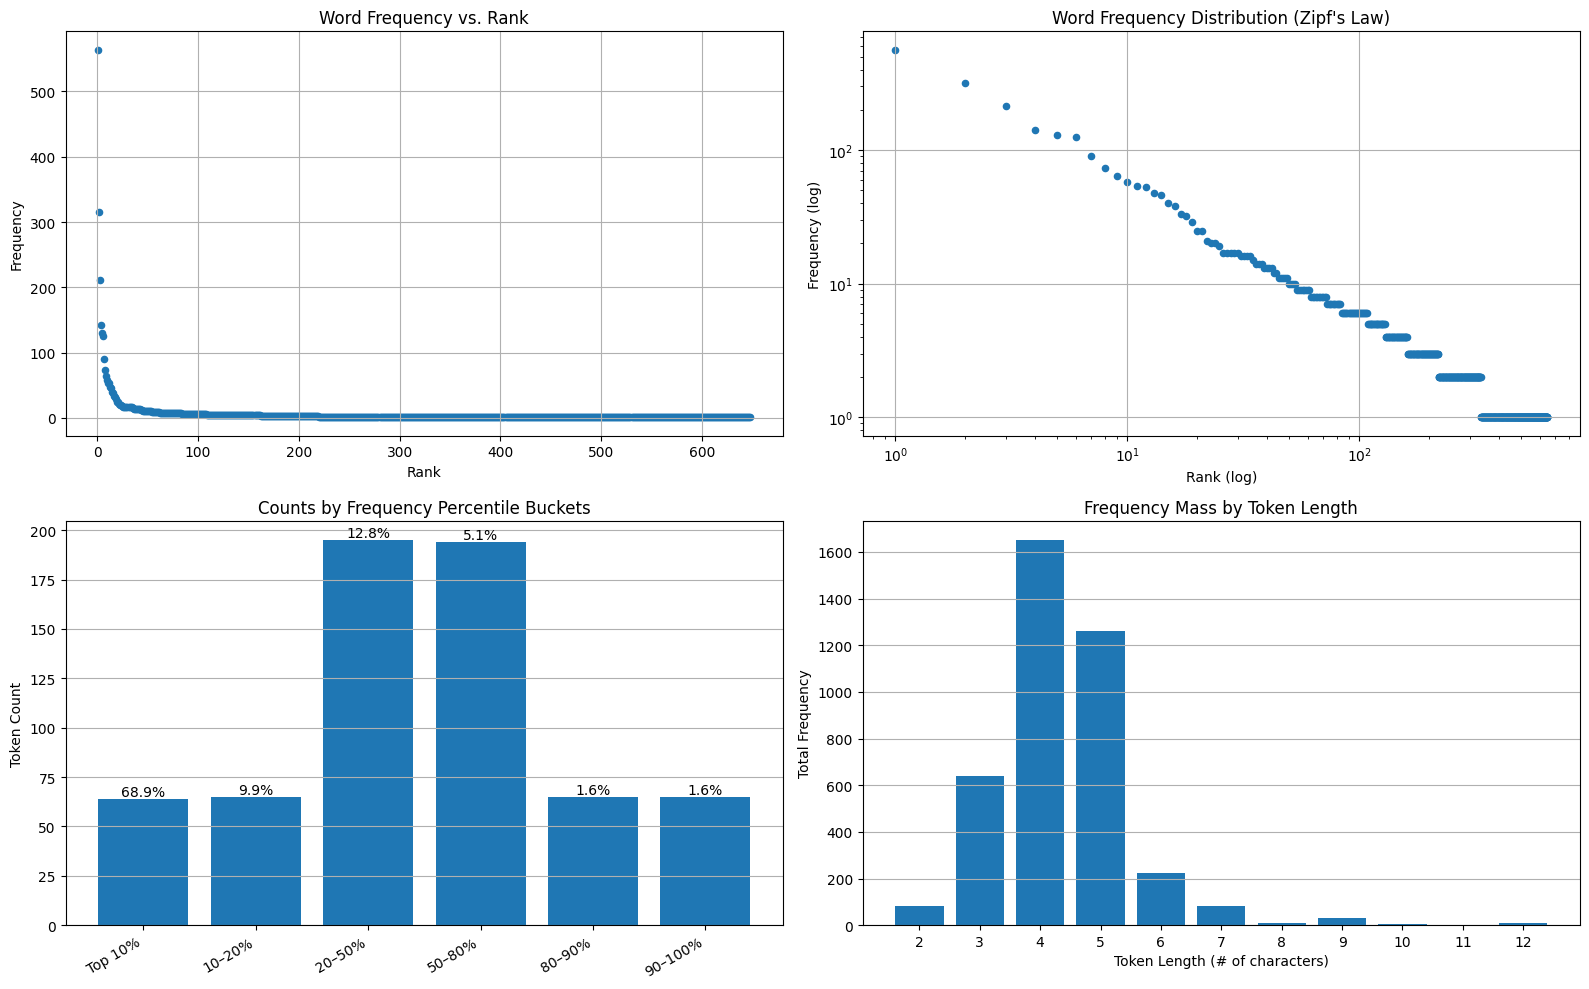

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Sort frequencies descending
freqs_sorted = np.array(sorted(lexicon.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted) + 1)

# -- precompute percentile buckets (by rank)
N = len(freqs_sorted)
pct_edges = [0, 10, 20, 50, 80, 90, 100]  # buckets: Top10, 10–20, 20–50, 50–80, 80–90, 90–100 (tail)
idx_edges = [int(np.floor(p/100 * N)) for p in pct_edges]
labels = [f"Top {pct_edges[1]}%"] + [f"{pct_edges[i]}–{pct_edges[i+1]}%" for i in range(1, len(pct_edges)-1)]

bucket_counts = []
bucket_mass_share = []
total_mass = freqs_sorted.sum()
for i in range(len(idx_edges)-1):
    lo, hi = idx_edges[i], idx_edges[i+1]
    cnt = max(hi - lo, 0)
    bucket_counts.append(cnt)
    mass = freqs_sorted[lo:hi].sum() if cnt > 0 else 0
    bucket_mass_share.append(100.0 * mass / total_mass if total_mass > 0 else 0.0)

# --- length histogram (1-char, 2-char, 3-char, ...) weighted by frequency
length_mass = {}
for token, c in lexicon.items():
    L = len(token)
    length_mass[L] = length_mass.get(L, 0) + c
lengths = np.array(sorted(length_mass.keys()))
length_counts = np.array([length_mass[L] for L in lengths])

# ---- 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) Simple scatter plot (rank vs frequency)
axes[0, 0].scatter(ranks, freqs_sorted, s=20)
axes[0, 0].set_xlabel("Rank")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Word Frequency vs. Rank")
axes[0, 0].grid(True)

# 2) Zipf's Law (log-log)
axes[0, 1].scatter(ranks, freqs_sorted, s=20)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Rank (log)")
axes[0, 1].set_ylabel("Frequency (log)")
axes[0, 1].set_title("Word Frequency Distribution (Zipf's Law)")
axes[0, 1].grid(True)

# 3) Percentile bucket counts
x = np.arange(len(labels))
axes[1, 0].bar(x, bucket_counts)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=30, ha="right")
axes[1, 0].set_ylabel("Token Count")
axes[1, 0].set_title("Counts by Frequency Percentile Buckets")
axes[1, 0].grid(True, axis="y")
# annotate each bar with its mass share
for i, (xc, cnt, mass_pct) in enumerate(zip(x, bucket_counts, bucket_mass_share)):
    if cnt > 0:
        axes[1, 0].text(xc, cnt, f"{mass_pct:.1f}%", ha="center", va="bottom")

# 4) Length histogram (frequency-weighted)
axes[1, 1].bar(lengths, length_counts, width=0.8)
axes[1, 1].set_xticks(lengths)
axes[1, 1].set_xlabel("Token Length (# of characters)")
axes[1, 1].set_ylabel("Total Frequency")
axes[1, 1].set_title("Frequency Mass by Token Length")
axes[1, 1].grid(True, axis="y")

plt.tight_layout()
plt.show()


#### **Plots 1 & 2**

This might be an extreme case of Zipf's law, but the frequency of the word is strongly inversely related to its rank

Nonetheless, when reconstructing the words from the disjoint words, we'll ensure that we give more frequent words more weight, sort of a probabilistic approach. The priors being the frequency of the term in the lexicon relative to the other terms.

#### **Plot 3**

The top 10% most frequent tokens appear in 67.6% of the normalized corpus. Whereas the bottom 30% tokens appear in less than 10% of the corpus. To be cautious but also remove things that are less frequent, we'll remove the buttome 10% of tokens. 

In [61]:
# Just to be sure let's see some of those buttom 10%
items_sorted = sorted(lexicon.items(), key=lambda x: x[1])  
N = len(items_sorted)

# Bottom 10% by rank
pct = 10
cutoff_idx = min(int(np.ceil(pct / 100 * N)), 15)
bottom_10 = items_sorted[:cutoff_idx]

print(f"Bottom {pct}% tokens by rank (capped at 15 tokens):")
for token, freq in bottom_10:
    print(f"{token}: {freq}")

Bottom 10% tokens by rank (capped at 15 tokens):
مبسط: 1
برونزالفاء: 1
اماراتي: 1
هان: 1
رويال: 1
حليب: 1
سوبر: 1
سمارت: 1
ريمون: 1
موديل: 1
برنزالفاء: 1
سيليكون: 1
اكر: 1
طبشه: 1
درفه: 1


The words appear to be meaningful, so we'll not drop any.

#### **Plot 4**

Most words fall within 3 and 7 characters. Let's see some examples of the extremes at 2 chars and >=9 chars long:

In [62]:
{k: v for k, v in lexicon.items() if len(k) == 2}

{'رش': 4,
 'شب': 9,
 'دن': 1,
 'حر': 11,
 'سد': 8,
 'اي': 5,
 'لب': 3,
 'خط': 1,
 'حب': 1,
 'كل': 1,
 'يا': 1,
 'ات': 11,
 'تر': 1,
 'جد': 3,
 'يد': 2,
 'ين': 1,
 'نص': 1,
 'يخ': 5,
 'جي': 1,
 'دي': 2,
 'شر': 1,
 'ال': 1,
 'خا': 1,
 'قص': 5,
 'سن': 1,
 'صب': 1,
 'مت': 2}

In [63]:
{k: v for k, v in lexicon.items() if len(k) >= 9}

{'برونزالفاء': 1,
 'برنزالفاء': 1,
 'المستعماره': 2,
 'بوصهبلاستيك': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'الابعادpanel': 8,
 'والقسامات': 1,
 'واالكسسوارات': 1,
 'ايزوبروبيل': 1,
 'حديدتسليح': 4,
 'استتواريو': 1}

There is a mix between words that are uninterpretable and ones that are not. Unfortunately this may be a byproduct of the CAMel-tools tokenizer-disambiguator combo, which was our only efficient hope of normalizing and lemmatizing the tokens. Hence, this approach will suffice for now. More efforts could be shed on improving the normalization phase so we can further optimize the lexicon.

**Note:** I'll manually clean these tokens to improve our lexicon.

In [64]:
# Extract and remove tokens surgically
extract_map = {
    'الابعادpanel': ['الابعاد', 'panel'],
    'بوصهبلاستيك': ['بلاستيك'],
    'واالكسسوارات': ['اكسسوارات'],
    'برونزالفاء': ['برونز'],
    'برنزالفاء': ['برونز'],
    'والقسامات': ['قسامات'],
    'حديدتسليح': ['حديد','تسليح'],
}

# Apply extractions
for src, parts in extract_map.items():
    if src in lexicon:
        for p in parts:
            p = preprocess_text(p)
            if p in lexicon:
                lexicon[p] += 1
            else:
                lexicon[p] = 1
        lexicon.pop(src, None)

remove_words = {
    'شب','دن','حر','اي','لب','حب','كل','يا','ات','تر','جد','يد','ين','يخ','جي','دي','شر','ال','خا','سن','مت',
    'استتواريو', 'المستعماره'
}

for bad in remove_words:
    lexicon.pop(bad, None)

{k: v for k, v in lexicon.items() if len(k) >= 9 or len(k) == 2}

{'رش': 4,
 'سد': 8,
 'اكسسوارات': 9,
 'الخرسانيه': 17,
 'خط': 1,
 'نص': 1,
 'ايزوبروبيل': 1,
 'قص': 5,
 'صب': 1}

## Combine disjointed letters
Combining the letters based on the lexicon is only one half of the solution, the harder part is understanding the boundaries of words where letters are disjointed and ambiguous.

### Research findings


This problem could be cut in three parts:
1. Find unigram probability for each lexicon entry
    - We don't have a large enough corpus to use ngrams, plus we don't know the boundaries of words
2. Create a Trie data structure from the lexicon
3. Traverse the Trie and determine the word with most likelihood
    - We could go about the traversal using a greedy approach, which means looking at each word in the sentence alone, but I've decided to follow a better approach (Viterbi algo.) which looks at how the words fit in a sentance

### ***Trie and Viterbi Segment technique***

#### Algorithm

In [65]:
# Node definition for the Trie
class TrieNode: 
    __slots__ = ("ch","end","logp")
    def __init__(self):
        self.ch = {} # Children nodes dictionary
        self.end = False # Boolean: node marks a word's end
        self.logp = float("-inf") # Likelihood for this word, only relevant if end is True 

# Trie structure to hold the lexicon
class Trie:
    def __init__(self):
        self.root = TrieNode()
    def insert(self, word, logp): # Insert a node in the Trie
        node = self.root
        for c in word:
            node = node.ch.setdefault(c, TrieNode()) # If there's a node for c return it, else create a new node for c
        node.end = True
        node.logp = logp
    def in_trie_prefix(self, s): # Checks if the string/word is in our Trie
        node = self.root
        for ch in s:
            if ch not in node.ch:
                return False
            node = node.ch[ch]
        return node.end

# The blueprint to creating the Trie DS
def build_trie_from_counts(counts, alpha=0.0):
    # counts: dict[word] -> int
    V = len(counts) # Vocabulary size
    Z = sum(counts.values()) + alpha * V # Denominator = N_train (total no. of words) + weighted V
    T = Trie()
    for w, c in counts.items():
        p = (c + alpha) / Z
        T.insert(w, log(p))
    return T

def viterbi_segment(chars, trie, del_char_logp=log(6.7e-3)): # ≈ -5.00
    """chars: e.g. 'catsanddog' (spaces removed). Returns words and score."""

    if chars == "":
        return "", 1
    
    n = len(chars)
    best = [float("-inf")] * (n + 1)
    back = [None] * (n + 1) # (end of word index for word starting at i: int, start of a word: boolean)
    best[n] = 0.0  # empty suffix has score 0

    # This loop begins at the end of the sentence, to evaluate all possible word formations taking into account the entire sentence
    for i in range(n - 1, -1, -1): 
        node = trie.root
        j = i
        while j < n and chars[j] in node.ch: # Check if the char exists in the children of the current node
            node = node.ch[chars[j]] # Look at the branch associated with chars[j]
            j += 1
            if node.end: # If chars[i:j] completes a word, then step in
                cand = node.logp + best[j] # The core of the Viterbi DP; considers likelihood of chars[i:j] and even chars[j:] 
                if cand > best[i]:
                    best[i] = cand
                    back[i] = (j, True)
        
        # Mark char position as a skip when it doesn't form a word and propagate logp.
        # This helps when the end of the sentence isn't found in lexicon/Trie.
        # The del_char_logp is added to penalize skipping characters
        cand_skip = best[i+1] + del_char_logp  
        if cand_skip > best[i]:
            best[i] = cand_skip
            back[i] = (i+1, False)

    # Reconstruct the words
    words = []
    i = 0
    while i < n:
        j, is_word = back[i]
        if is_word: # i.e. character at i isn't marked as skip
            words.append(chars[i:j])
        i = j

    
    
    if len(words) == 1: # Sometimes we'll only recognize one word; let's flag the case with 1
        return words, 1
    
    elif not words: # In case we failed to construct any words; flag with 0
        return "Unknown", 0
    
    else: # We found a list of words; return the score (<0) and join by space later to reconstruct sentence
        return words, best[0]

##### Notes (the key decisions in implementing the algorithm)


- **Scoring**
  
  - Use natural-log probabilities: `node.logp = log p(w) ≤ 0`.  
  - Base case: `best[n] = 0.0` (log 1). A fallback case when no words are found.

- **Transitions at position i**
  
  - **Words:** for each trie end at `j`, candidate = `node.logp + best[j]`.  
  - **Skip 1 char:** candidate = `best[i+1] + del_char_logp`. Always include it as a competitor (not just a fallback).

- **Skip penalty**
  
  - Set `del_char_logp = log(p_del)` with `0 < p_del << 1` (same log base).  
  - Example: `del_char_logp = log(6.7e-3) ≈ -5.0`.  

- **Decision intuition (per-char threshold)**
  
  - Word of length `L` beats skipping those `L` chars iff  
    `log P(w) > L * del_char_logp` ⇔ `(log P(w))/L > del_char_logp`.  
  - So `del_char_logp` acts as a per-character quality threshold.

- **Correction to earlier intuition**
  
  - Choosing a word at `[i:j)` does **not** force later scores below `best[j+1]`.  
  - With a **negative** skip penalty, a strong word can outperform a run of skips by avoiding `L * |del_char_logp|`.

- **Bias toward frequent words**
  
  - Already handled by larger (less negative) `log P(w)`.  
  - Tune `del_char_logp` to trade off segmentation vs. deletions; already tried multiple hyperparamters.

##### A few tests


In [66]:
# Toy example
counts = {
    "cat": 40, "cats": 30, "sand": 5, "and": 20, "an": 25, "dog": 70
}
trie = build_trie_from_counts(counts, alpha=1.0)
words, score = viterbi_segment("catsanddogfiller", trie)
print(words)  # e.g., ['cats', 'and', 'dog'] 


['cats', 'and', 'dog']


We purposfully choose to find `an` in the sentence above. Although `and` is the right choice, we can't be certain of which word is right all the time unless we resort to an LLM or another expensive technique that is context aware. Hence, choosing based on frequency and propagated log likelihood is a sufficient heuristic.

In [67]:
# Example from our data

trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود'] -27.056923875693155


In [68]:
trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[2833], trie_ar)
print(df["Disjointed"].iloc[2833])
print(words, score)

حديدمجدولاتفاقملممترسعود
['حديد', 'مجدول', 'اتفاق'] -60.75549874753403


###### More tests - ignore

In [101]:
print("سماكه in trie?", trie_ar.in_trie_prefix("سماكه"))

سماكه in trie? True


In [70]:
print("مجدول in trie?", trie_ar.in_trie_prefix("مجدول"))

مجدول in trie? True


In [71]:
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود'] -27.056923875693155


In [72]:
chars = "صاجاسودملمت"
counts = {"صاج" : 1, "اسود" :1, "ملمت" : 1}

trie = build_trie_from_counts(lexicon)
seg, score = viterbi_segment(chars, trie_ar)

print(seg, score)

['صاج', 'اسود'] -27.056923875693155


In [73]:
print("صاج in trie?", trie_ar.in_trie_prefix("صاج"))
print("اسود in trie?", trie_ar.in_trie_prefix("اسود"))

صاج in trie? True
اسود in trie? True


### Rejoining the disjointed letters
Now we can reconstruct the disjointed letters in the Item Name column

In [74]:
def segment_and_join(text, trie):
    words, score = viterbi_segment(text, trie)
    
    # Catch edge cases
    if score == 0 or score == 1:
        return words
    
    # Join words with spaces
    else: 
        return " ".join(words)

#### Rejoined column created

In [75]:
df["Rejoined"] = ''
df["Rejoined"] = (df["Disjointed"].apply(lambda t: segment_and_join(t, trie_ar))).str.strip()

In [76]:
# Let's see the results
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,
743,كيس مادة,كيس ماده,,
901,GATE BARIAR PANEL2,gate bariar panel,,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود


In [77]:
df["Rejoined"].iloc[2833]

'حديد مجدول اتفاق'

#### Combined column created

In [78]:
# Now let's add a new fully preprocessed column
df["Combined"] = (
    df["Normalized"].fillna("").str.strip() + " " + df["Rejoined"].fillna("").str.strip()
).str.strip()
df.iloc[[439, 743, 901, 1563, 1663]]

,Item Name,Normalized,Disjointed,Rejoined,Combined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,,تيوب المنيوم مستطيل
743,كيس مادة,كيس ماده,,,كيس ماده
901,GATE BARIAR PANEL2,gate bariar panel,,,gate bariar panel
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود,صاج اسود
1663,XT1N 160 TMD 40-450 3p F F,xt tmd,,,xt tmd


In [79]:
df_test = df[df["Disjointed"] != ""]
df_test.to_excel("../data/reconstructed_entries.xlsx")
df_test.head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
1562,ﺻ ﺎ ﺝ ﺍ ﺳ و د 1220 * 2440 * 20 ﻣ ﻠ,,صاجاسودمل,صاج اسود,صاج اسود
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت,صاج اسود,صاج اسود
1565,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 4.0 ﻣ ﻝ 12 ﻣ ﺗ ﺭ,,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1566,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1567,ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,,تيوبفارغمربعملمتر,تيوب فارغ مربع,تيوب فارغ مربع


## Analyze tokens

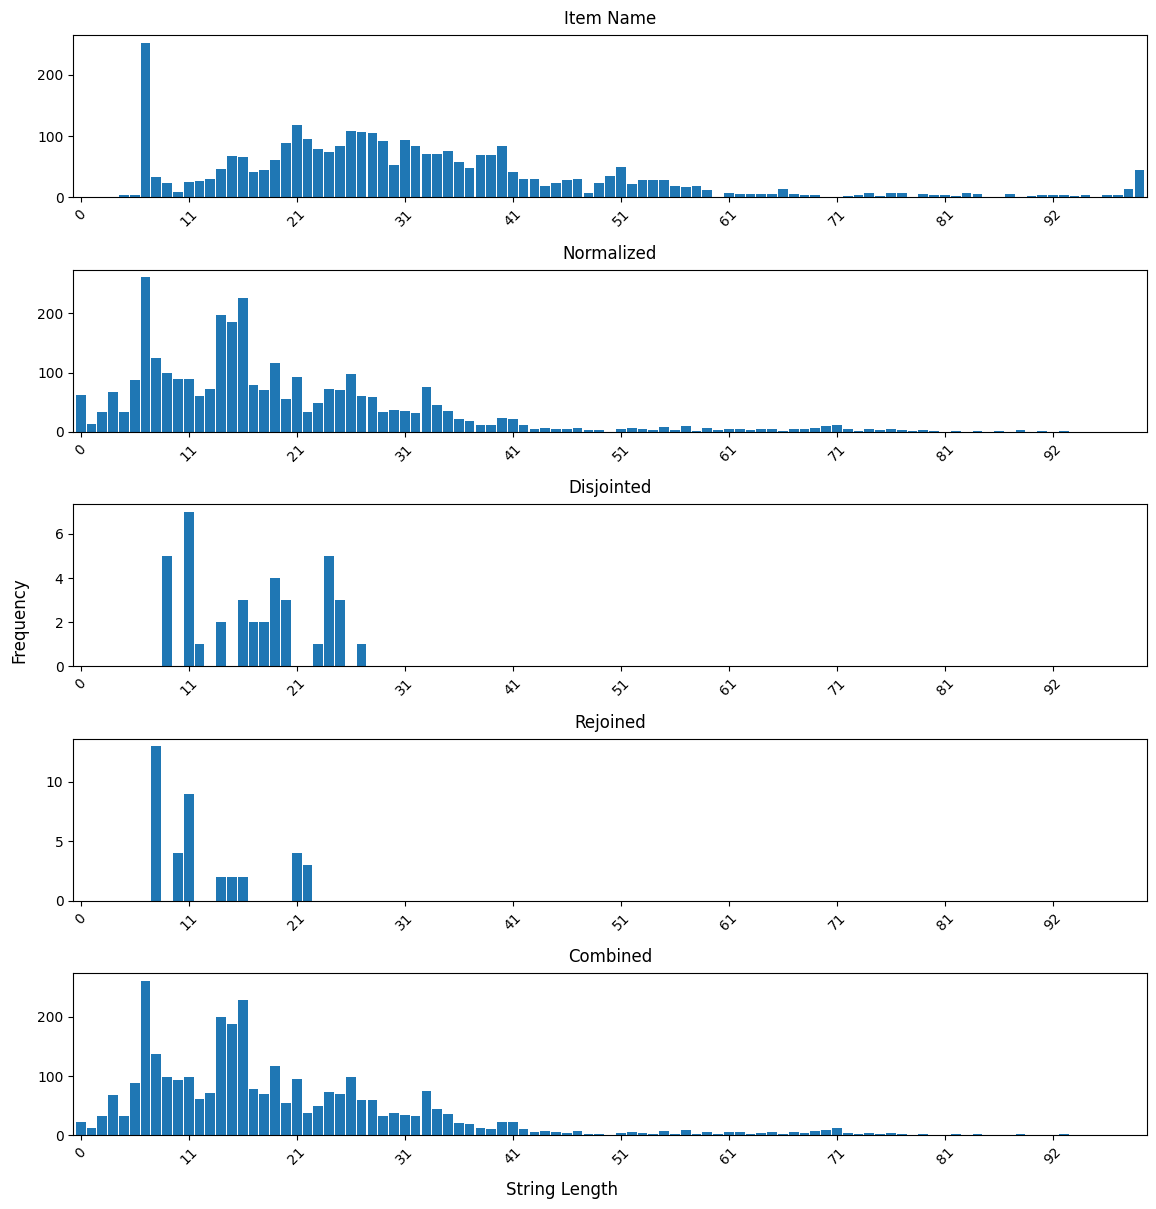

In [80]:
# Visualize the character lengths per preprocessing stage

# Columns where zero-length is an artifact you'd like to ignore
drop_zero_len_cols = {"Disjointed", "Rejoined"}

length_counts = {}
for col in df.columns:
    lengths = df[col].astype(str).str.len()
    if col in drop_zero_len_cols:
        lengths = lengths[lengths > 0]  # drop zeros only for these columns
    length_counts[col] = lengths.value_counts().sort_index()

# Put into a DataFrame (rows = lengths, columns = original columns)
length_counts_df = pd.DataFrame(length_counts).fillna(0).astype(int)

# Plot histograms per column with cleaner style
fig, axes = plt.subplots(len(length_counts_df.columns), 1, figsize=(12, 2.5*len(length_counts_df.columns)), sharex=False)

for ax, col in zip(axes, length_counts_df.columns):
    length_counts_df[col].plot(kind="bar", ax=ax, width=0.9)
    ax.set_title(col, fontsize=12, pad=8)
    
    # Show only ticks at 0, 10, 20, ... up to 100
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Rotate x labels for readability
    ax.tick_params(axis="x", rotation=45)

# Global x label
fig.text(0.5, 0.04, "String Length", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [81]:
df[df["Combined"] == ""].head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
1675,S201-C10,,,,
1676,S203-C6,,,,
1681,S203-C63,,,,
1697,S201-C16,,,,
1698,S202-C10,,,,


After normalization many of the original Item Names shrunk down as a result of removing digits, untis, etc., while some empty rows arose as a result of cleaning disjoint letters. 

Disjointed and Rejoined also exhibit a similar trend. To clear something first, the plot shows only the rows where there were values (disjoint letters). Overall, the sentence legnths shrunk due to some words found in the respective rows not being present in the lexicon. However, we can clearly see that no rows were completely eliminated; we successfully brought back some context from the disjoint letters.

Lastly, the combined letters match the distribution of the normalized column. This is normal as we only added 39 rows from Rejoined, and that didn't change the distrubution by much.

All in all. Most rows have at least a few characters/words that we could extract the context of the purchase from. Notably, there are some 0-char rows in Combined which are English entries (e.g., S201-C10) where digits and symbols were removed and letters were left disjoint. We'll decide what to do with these later. ~z

In [82]:
df[df["Combined"].str.len() == 3].head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
497,C35 / OPC,opc,,,opc
532,C35 SCC - 450,scc,,,scc
553,HEA 200*190*12m,hea,,,hea
635,صاج 1.2*4*8,صاج,,,صاج
636,صاج 1.22*6 متر*8 مم,صاج,,,صاج


In [83]:
# Let's see how many unique words we've got
df["Combined"].nunique()

1267

## Reduced tokens

## Numerical tokens

# Train classifier

In [84]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
import hdbscan

en_stop = set(__import__('sklearn').feature_extraction.text.ENGLISH_STOP_WORDS)
stop_words = list(en_stop | AR_STOP)

# 1) Load your preprocessed texts
texts = df["Combined"].astype(str).tolist()   # your clean column

# 2) Multilingual embeddings (CPU okay)
embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 3) Vectorizer tuned for short text
vectorizer_model = CountVectorizer(
    ngram_range=(1,3), min_df=2, stop_words=stop_words, max_features=30000
)

# 4) UMAP + HDBSCAN
umap_model = UMAP(n_neighbors=15, n_components=5, metric="cosine", random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25, metric='euclidean',
                                cluster_selection_method='eom', prediction_data=True)

# 5) Build BERTopic
topic_model = BERTopic(
    embedding_model=embedder,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=False
)

topics, probs = topic_model.fit_transform(texts)

# Inspect
topic_info = topic_model.get_topic_info()     # topic sizes + labels
top_words_0 = topic_model.get_topic(0)        # [(word, weight), ...]


In [85]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,790,-1_pcs_bend_مقاس_مقاس سماكه,"[pcs, bend, مقاس, مقاس سماكه, سماكه طول, طول, ...","[ماسوره حديد مقاس سماكه طول, ماسوره حديد مقاس ..."
1,0,240,0____,"[, , , , , , , , , ]","[unknown, unknown, unknown]"
2,1,236,1_مجلفن_سلك_كوع_رمادي,"[مجلفن, سلك, كوع, رمادي, rebar saudi, منار, حد...","[صاج حديد مجلفن مقاس سماكه, صاج حديد مجلفن مقا..."
3,2,169,2_صاج اسود_اسود_صاج_حديد ويل,"[صاج اسود, اسود, صاج, حديد ويل, ويل, ماسوره اس...","[صاج اسود, صاج اسود, صاج اسود]"
4,3,138,3_عادي_كيبل_fp_سرايا,"[عادي, كيبل, fp, سرايا, ac, نامات ربر, iec, نا...","[لب عادي بالستيك نامات ربر, لب عادي بالستيك نا..."
5,4,118,4_تسليح سابك_حديد تسليح سابك_سابك حديد تسليح_س...,"[تسليح سابك, حديد تسليح سابك, سابك حديد تسليح,...","[حديد تسليح سابك, حديد تسليح سابك, حديد تسليح ..."
6,5,92,5_steel_concrete_kludi_kludi rak,"[steel, concrete, kludi, kludi rak, chrome, tu...",[kludi rak abs shattaf with hose and holder ch...
7,6,84,6_سماكه صاج حديد_سماكه صاج_صاج حديد_صاج حديد اسود,"[سماكه صاج حديد, سماكه صاج, صاج حديد, صاج حديد...","[صاج حديد اسود سماكه, صاج حديد اسود سماكه, صاج..."
8,7,81,7_ppr_pipe_tahweeltm_ppr tahweeltm,"[ppr, pipe, tahweeltm, ppr tahweeltm, tee ppr,...","[equal tee ppr tahweeltm, ppr pipe, ppr pipe]"
9,8,80,8_اتفاق حديد تسليح_اتفاق حديد_اتفاق_حديد تسليح,"[اتفاق حديد تسليح, اتفاق حديد, اتفاق, حديد تسل...","[حديد تسليح اتفاق, حديد تسليح اتفاق, حديد تسلي..."


# Appendix

## Tests

### Trying out normlization techniques

In [86]:
text = "ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ"
text

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [87]:
# This does a good job in standardizing the characters
import unicodedata
result = unicodedata.normalize("NFKC", text)
result

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [88]:
import re
result = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', text)
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [89]:
result = re.sub(r'\s+', ' ', text).strip()
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

None of the techniques above effictively resolves the issue of spaces and word recognition in text...

We'll try out Camel-tools, I've had a little experience with it before, but never worked with data this messy

In [90]:
import camel_tools.utils.normalize as norm

In [91]:
norm.normalize_unicode(text)

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [92]:
from camel_tools.utils.dediac import dediac_ar
dediac_ar(norm.normalize_unicode(text))

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [93]:
# Oh they're well indexed
chars = "سلام"
print(chars[0], chars[1])

س ل


In [94]:
# What about this
for i in range(len(chars)- 1, -1, -1): 
    print(chars[i])

م
ا
ل
س


In [95]:
mle = MLEDisambiguator.pretrained('calima-msa-r13')
sample_words = {'برنزالفاء': 1,
 'الكهربائي': 1,
 'المواصفات': 2,
 'والمخططات': 1,
 'المخططات': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'والقسامات': 1,
 'حديدتسليح': 4,
 'استتواريو': 1,
 'المنيوم': 1,
 'برغي': 1,
 'كهربائي': 1,
 'اسود': 1,
 'الوطن': 1,
 'كهرباء': 1}
samples = " ".join(sample_words.keys())

words = simple_word_tokenize(samples)

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True)
segmented = mtok.tokenize(words)
segmented

['برنزالفاء',
 'ال+',
 'كهربائي',
 'ال+',
 'مواصفات',
 'و+',
 'ال+',
 'مخططات',
 'ال+',
 'مخططات',
 'أكسسوارات',
 'الخرسانيه',
 'والقسامات',
 'حديدتسليح',
 'استتواريو',
 'ألمنيوم',
 'برغي',
 'كهربائي',
 'أسود',
 'ال+',
 'وطن',
 'كهرباء']

In [96]:
def preprocess_text_test(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)

    # 3) Split on whitespace (since we've cleaned everything else to spaces)
    tokens = text.split()

    # 4.1) Remove dimensions/units for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR]

    # 4.2) Lemmatize and remove clitics for lexicon
    if no_disjointed:
        print(tokens)
        lemm = [tokenizer.tokenize([t]) for t in tokens]
        print(lemm)
        tokens = [''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
        print(tokens)

    # 4.3) Drop single-letter tokens, repeated chars, and deduplicate within the row for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)
    
text = "سابك "#"المواصفات balorina الكهربائي والكهربائي وكهربائي كهرباء المخططات"
preprocess_text_test(text)

['سابك']
[['س+', 'أبك']]
['ابك']


'ابك'

### Optimizing functions and testing ChatGPT suggestions

In [97]:
import re
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar

# Unicode ranges that cover Arabic letters (not presentation forms)
_AR = r'\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'

def normalize_mixed_arabic(s: str) -> str:
    # 1) Canonical/compatibility normalization
    s = normalize_unicode(s, compatibility=True)
    # 2) Normalize alef maqsura, optional but useful
    s = normalize_alef_maksura_ar(s)

    # 3) Strip zero-width/bidi formatting chars
    s = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', s)

    # 4) Normalize common operators and pad them
    #    Treat *, ×, x as multiplication; surround with single spaces
    s = re.sub(r'\s*([*xX×])\s*', r' × ', s)

    # 5) **Key step**: remove spaces *only* between Arabic letters
    #    This stitches scattered letters back into words
    s = re.sub(fr'(?<=[{_AR}])\s+(?=[{_AR}])', '', s)

    # 6) Collapse remaining excessive whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# Demo on your string
sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(normalize_mixed_arabic(sample))


تیوبفارغمربع 80 × 80 × 5 مل 6 متر


In [98]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# 1) choose a pretrained analyzer/disambiguator (MSA shown)
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# 2) after your intra-letter stitching + spacing heuristics:
clean = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"#"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

['تیوبفارغمربع', '80', '×', '80', '×', '5', 'مل', '6', 'متر']

In [99]:
[' '.join(normalize_text(t) for t in words if '+' not in t) ]

['تيوبفارغمربع 80 × 80 × 5 مل 6 متر']

In [100]:
import re
import unicodedata
from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar     # ة -> ه or keep ة depending on needs
)
from camel_tools.utils.dediac import dediac_ar

# Arabic block after NFKC
ARABIC_RANGE = r"\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF"
AR_LETTER = f"[{ARABIC_RANGE}]"
DIGIT = r"[0-9\u0660-\u0669]"  # Western + Arabic-Indic

def to_ascii_digits(s: str) -> str:
    # map Arabic-Indic digits to ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")
    return s.translate(trans)

def normalize_ar_text(s: str, keep_diacritics=False):
    # 1) collapse presentation forms, compatibility, widths, etc.
    s = unicodedata.normalize("NFKC", s)

    # 2) remove tatweel and bidi/formatting chars
    s = s.replace("\u0640", "")  # tatweel
    s = re.sub(r"[\u200c\u200d\u200e\u200f\u061c]", "", s)  # ZWNJ/ZWJ/LRM/RLM/ALM

    # 3) unify common Arabic variants
    s = normalize_alef_ar(s)
    s = normalize_alef_maksura_ar(s)
    s = normalize_teh_marbuta_ar(s)

    # 4) optional: strip diacritics (recommended for noisy sources)
    if not keep_diacritics:
        s = dediac_ar(s)

    # 5) digits to ASCII for easier heuristics
    s = to_ascii_digits(s)

    return s

def fix_spaced_glyphs(s: str):
    s = normalize_ar_text(s)

    # --- spacing repair heuristics ---

    # A) collapse spaces inserted between Arabic letters (re-form words)
    # remove spaces when both sides are Arabic letters
    s = re.sub(fr"(?<={AR_LETTER})\s+(?={AR_LETTER})", "", s)

    # B) ensure spaces around math operators and 'x'
    s = re.sub(r"\s*([*+\-/x×])\s*", r" \1 ", s)

    # C) split between letters and digits (both directions)
    s = re.sub(fr"(?<={AR_LETTER})(?={DIGIT})", " ", s)
    s = re.sub(fr"(?<={DIGIT})(?={AR_LETTER})", " ", s)

    # D) heuristic: insert a space when a right-joining (non-connecting-left) letter
    # is followed by another letter (helps recover word boundaries)
    non_joiners = "ادذرزوةى"  # letters that do not connect to the following letter
    s = re.sub(fr"(?<=[{non_joiners}])(?={AR_LETTER})", " ", s)

    # E) normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(fix_spaced_glyphs(sample))


تیو بفا ر غمر بع 80 * 80 * 5 مل 6 متر
